<a href="https://colab.research.google.com/github/alehpineda/credit_card_fraud_detection/blob/master/Week03_HW_Alejandro_Hernandez_Pineda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all the libraries!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# check these libraries
import gc, os, sys
import re

sns.set_style('whitegrid')
sns.set()

# scikit learn libraries
from sklearn import  metrics, preprocessing
from sklearn.decomposition import PCA

pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline

# Fraud detection

## Task

- Explore the dataset
- Decide which features are important
- Perform machine learning
- Test the model on the testing set


# Explore the dataset

In [0]:
# Load the data from google drive
!pip install -U -q PyDrive


In [0]:
# Authenticate from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [4]:
%%time
# Download the datasets!

# Links from my google drive
train_identity = 'https://drive.google.com/open?id=1Ryrgj8fbNzvRkcpwTkEg4h0hk5tU8LAB'
train_transaction = 'https://drive.google.com/open?id=1XMyun2KDHUOU0w6T49L5SKo1BkcPkLhX'
test_identity = 'https://drive.google.com/open?id=1HxI06NM9qaymbh308XH9rSht8zZ7sARX'
test_transaction = 'https://drive.google.com/open?id=1_SS8h_q21Vr1nOZ1r-eLng7aNCBVuWtD'

# get the id from the link
fluff1, id1 = train_identity.split('=')
fluff2, id2 = train_transaction.split('=')
fluff3, id3 = test_identity.split('=')
fluff4, id4 = test_transaction.split('=')

# Get the files
downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('train_identity.csv')

downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('train_transaction.csv')

downloaded3 = drive.CreateFile({'id':id3}) 
downloaded3.GetContentFile('test_identity.csv')  

downloaded4 = drive.CreateFile({'id':id4}) 
downloaded4.GetContentFile('test_transaction.csv')


CPU times: user 1.76 s, sys: 5.08 s, total: 6.84 s
Wall time: 12.5 s


In [5]:
%%time
# Load the datasets!

# Training set
train_id = pd.read_csv('train_identity.csv', low_memory=False)
train_trn = pd.read_csv('train_transaction.csv', low_memory=False)
# Test set
test_id = pd.read_csv('test_identity.csv', low_memory=False)
test_trn = pd.read_csv('test_transaction.csv', low_memory=False)


CPU times: user 1min 51s, sys: 17.3 s, total: 2min 8s
Wall time: 2min 9s


In [0]:
# Function to reduce memory usage 
"""
https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
"""

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
%%time
# Reduce the memory of the dataframes

train_id = reduce_mem_usage(train_id)
train_trn = reduce_mem_usage(train_trn)
test_id = reduce_mem_usage(test_id)
test_trn = reduce_mem_usage(test_trn)


Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.86 MB
Decreased by 77.8%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
CPU times: user 3min 17s, sys: 10.1 s, total: 3min 27s
Wall time: 3min 27s


In [8]:
# Shape of the data
print(train_id.shape, test_id.shape)
print(train_trn.shape, test_trn.shape)


(144233, 41) (141907, 41)
(590540, 394) (506691, 393)


# Visualization

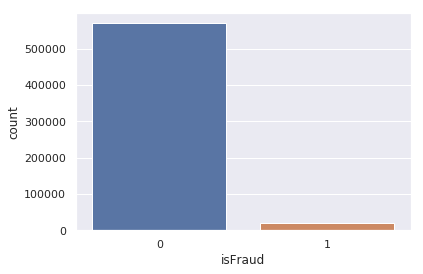

In [9]:
# Plot isFraud
sns.countplot(x = 'isFraud', data = train_trn)


In [10]:
train_trn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,nan,150.000,discover,142.000,credit,315.000,87.000,19.000,nan,NaN,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,nan,13.000,nan,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,117.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,117.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,credit,325.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,debit,330.000,87.000,287.000,nan,outlook.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,debit,476.000,87.000,nan,nan,yahoo.com,NaN,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,112.000,0.000,94.000,0.000,nan,nan,nan,nan,...,0.000,0.000,0.000,0.000,0.000,1.000,50.000,"1,758.000",925.000,0.000,354.000,0.000,135.000,0.000,0.000,0.000,50.000,"1,404.000",790.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,credit,420.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


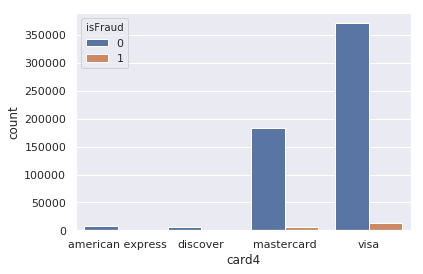

In [11]:
# Plot isFraud by type of card
sns.countplot(x = 'card4', hue='isFraud', data = train_trn)

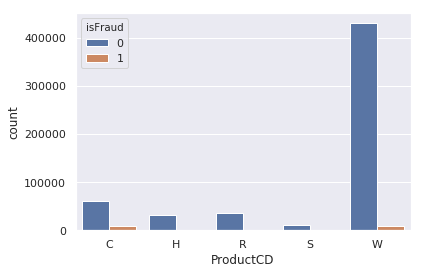

In [12]:
# Plot isFraud by type of card
sns.countplot(x = 'ProductCD', hue='isFraud', data = train_trn)

In [13]:
# Join the datasets
train_id_trn = pd.merge(train_id, train_trn[['isFraud', 'TransactionID']])
print(train_id_trn.shape, train_id.shape)

(144233, 42) (144233, 41)


In [14]:
train_id_trn.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,2987004,0.000,"70,787.000",nan,nan,nan,nan,nan,nan,nan,nan,100.000,NotFound,nan,-480.000,New,NotFound,166.000,nan,542.000,144.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,2987008,-5.000,"98,945.000",nan,nan,0.000,-5.000,nan,nan,nan,nan,100.000,NotFound,49.000,-300.000,New,NotFound,166.000,nan,621.000,500.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.000,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,2987010,-5.000,"191,631.000",0.000,0.000,0.000,0.000,nan,nan,0.000,0.000,100.000,NotFound,52.000,nan,Found,Found,121.000,nan,410.000,142.000,nan,nan,NaN,nan,nan,nan,NaN,Found,Found,NaN,chrome 62.0,nan,NaN,NaN,F,F,T,T,desktop,Windows,0
3,2987011,-5.000,"221,832.000",nan,nan,0.000,-6.000,nan,nan,nan,nan,100.000,NotFound,52.000,nan,New,NotFound,225.000,nan,176.000,507.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,NaN,chrome 62.0,nan,NaN,NaN,F,F,T,T,desktop,NaN,0
4,2987016,0.000,"7,460.000",0.000,0.000,1.000,0.000,nan,nan,0.000,0.000,100.000,NotFound,nan,-300.000,Found,Found,166.000,15.000,529.000,575.000,nan,nan,NaN,nan,nan,nan,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.000,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


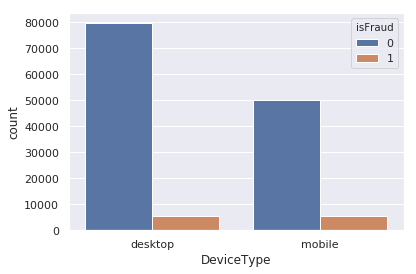

In [15]:
# Plot isFraud by DeviceType
sns.countplot(x = 'DeviceType', hue='isFraud', data = train_id_trn)

In [0]:
# Delete variables no longer using
del train_id_trn


# Feature engineering

In [0]:
# Merge the data
train = pd.merge(train_trn, train_id, on = 'TransactionID', how = 'left')
test = pd.merge(test_trn, test_id, on = 'TransactionID', how = 'left')


In [18]:
# Delete columns with more than 90% of nulls and 90% repeated values

# Funtion that returns name of colum if over 90% of the values are null
def delnullcol(df):
    nullcol = [col for col in df.columns if df[col].isnull().sum()/df.shape[0] >= 0.9]
    return nullcol

# Function that returns name of the columns that over 90% of their value are repeated
def repcols(dt):
    rep_vals = [col for col in dt.columns if dt[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
    return rep_vals

# Function that returns a list with the names of the columns to drop
# and print the number of columsn to drop
def useless_cols(dt, exep):
    null_cols = delnullcol(dt)
    print("More than 90% null: " + str(len(null_cols)))
    too_many_repeated = repcols(dt)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(null_cols + too_many_repeated))
    cols_to_drop.remove(exep)
    return cols_to_drop

# Drop the columns
cols_to_drop = useless_cols(train, 'isFraud')
train = train.drop(cols_to_drop, axis=1)


More than 90% null: 12
More than 90% repeated value: 67


In [0]:
# Drop more columns
train = train.drop(['TransactionID', 'TransactionDT'], axis=1)


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 366 entries, isFraud to DeviceInfo
dtypes: category(29), float16(301), float32(34), int16(1), int8(1)
memory usage: 440.0 MB


In [21]:
# Which column is which type
print("Numerical: ",list(train.select_dtypes(include='number').columns.values))
print("Categorical: " ,list(train.select_dtypes(include='category').columns.values))


Numerical:  ['isFraud', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131

# Modeling pipeline

In [22]:
%%time
# Testing sklearn pipelines for pre processing, training, cross validation, and more
"""
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html
"""

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# X_train, y_train
y_train = train.pop('isFraud')
X_train = train.copy()

# We create the preprocessing pipelines for both numeric and categorical data.

# List of numerical features. Include 'number' is the numpy number types
numeric_features = list(X_train.select_dtypes(include='number').columns.values)
# Imputer, changes the null to -1, then uses a scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', StandardScaler())])

# List of categorical features. Include 'category' is the pandas category types
categorical_features = list(X_train.select_dtypes(include='category').columns.values)
# Imputer, changes the null to 'missing', then uses the one hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Join the changes in the categorical and numerical columns in the columnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)

# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', logistic)])


CPU times: user 681 ms, sys: 59 ms, total: 740 ms
Wall time: 762 ms


# Training

In [23]:
%%time
# Train
clf.fit(X_train, y_train)

# Simple scoring
print("model score: %.3f" % clf.score(X_train, y_train))

model score: 0.971
CPU times: user 1min 10s, sys: 1.96 s, total: 1min 12s
Wall time: 1min 12s


In [24]:
%%time
from sklearn.metrics import classification_report
# Prediction
y_pred = clf.predict(X_train)

# Classification report
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99    569877
           1       0.75      0.25      0.37     20663

    accuracy                           0.97    590540
   macro avg       0.86      0.62      0.68    590540
weighted avg       0.97      0.97      0.96    590540

CPU times: user 25.2 s, sys: 248 ms, total: 25.5 s
Wall time: 25.5 s


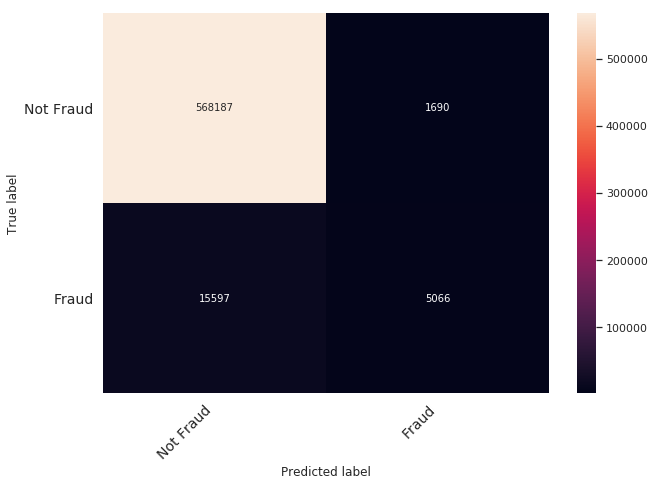

In [29]:
# Confusion matrix pretty print
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

print_confusion_matrix(confusion_matrix(y_train, y_pred), ['Not Fraud', 'Fraud']);
